In [1]:
#Development notes
#this script was last modified on 022917

#What this script does:
##Helps you define C to get the best estimator 

##Runs the model and get the r2 score

##Plots true vs predicted values

##Plots feature selection and their weights (univariant, svm weight and weight post selection)

#Note: for this example I use a linear kernel and Leave One Out cross validation

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from decimal import Decimal
from sklearn.svm import SVR 
from sklearn.model_selection import *
from sklearn.pipeline import make_pipeline
from sklearn import metrics  
import numpy as np

In [25]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
#Because the target of the iris dataset is discrete and not truely continuous
## we will add some noise 
y = iris.target
y=y+(np.random.random_sample(len(y),))


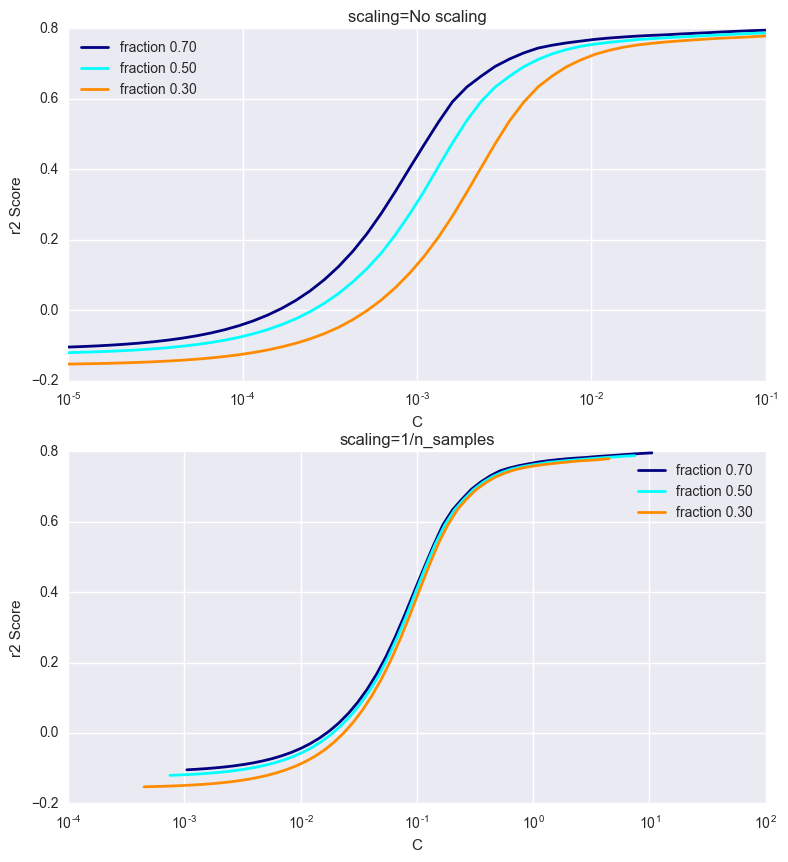

In [27]:
#Plot a range of C values to select best C to use for your model
## This code is Modified from 
##http://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html 
## Note that the timing of this step scales to the length of range of C values and the number of features
cRange=np.logspace(-5, -1)
n_samples=len(X)
clf_sets = [(SVR(C=1,kernel='linear'),cRange , X, y)]
colors = ['navy', 'cyan', 'darkorange']
lw = 2
for fignum, (clf, cs, X, y) in enumerate(clf_sets):
    # set up the plot for each regressor
    plt.figure(fignum, figsize=(9, 10))
    for k, train_size in enumerate(np.linspace(0.3, 0.7, 3)[::-1]):
        param_grid = dict(C=cs)
        # To get nice curve, we need a large number of iterations to
        # reduce the variance
        grid = GridSearchCV(clf, refit=False, param_grid=param_grid,
                            cv=ShuffleSplit(train_size=train_size,
                                            n_splits=250, random_state=1))
            
        try:
            grid.fit(X, y)
        #If the dataset is smaller all the test/train divisions might result in an error
        except ValueError:
            print("single classifier in train size ", train_size)
            break 
        scores = grid.cv_results_['mean_test_score']

        scales = [(1, 'No scaling'),
                    ((n_samples * train_size), '1/n_samples'),
                    ]

        for subplotnum, (scaler, name) in enumerate(scales):
            plt.subplot(2, 1, subplotnum + 1)
            plt.xlabel('C')
            plt.ylabel('r2 Score')
            grid_cs = cs * float(scaler)  # scale the C's
            plt.semilogx(grid_cs, scores, label="fraction %.2f" %
                             train_size, color=colors[k], lw=lw)
            plt.title('scaling=%s' % name)
            plt.legend(loc="best")
plt.show()

In [28]:
#Choose best C from above
##Cross validate, here I use LeaveOneOut() 
##Then return predictions and r2 score
clf=SVR(C=0.01, kernel='linear')
predicted = cross_val_predict(clf, X, y, cv=LeaveOneOut())
score=metrics.r2_score(y, predicted)
print('r2 score',score)
mod=(predicted,score)


r2 score 0.798247029397


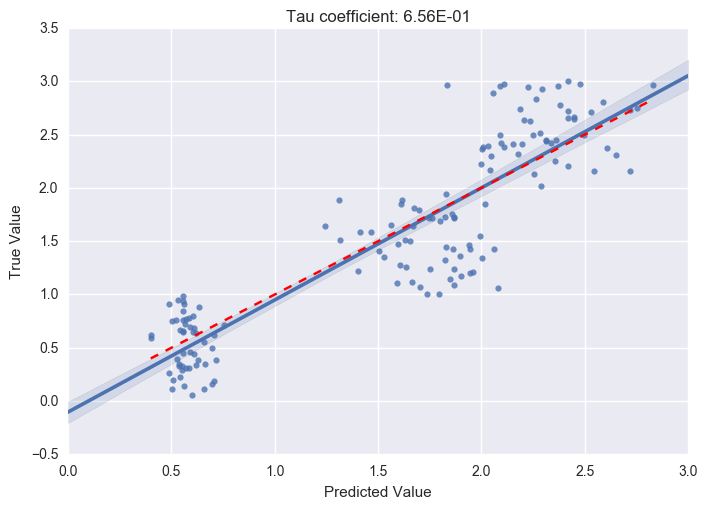

In [31]:
#Plot true vs model predicted values and calculate Tau coefficient
## If you think your data is normally distributed you can use a pearsonr instead
A=pd.DataFrame(data={'True Value':y,'Predicted Value':mod[0]})
x=A['True Value'].tolist()
y=A['Predicted Value'].tolist()
k=st.kendalltau(x,y)[0].item()
sns_plot=sns.regplot('Predicted Value','True Value',data=A)
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
##Make a dashed red line to show a perfect correlation
plt.plot([min(y), max(y)], [min(y), max(y)],'r--')
plt.title('Tau coefficient: %s'% ('%.2E' % (Decimal(k))))
plt.show()
